### import torch
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from torchvision.transforms import ToTensor, Lambda
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import pydicom
import numpy as np
from PIL import Image
import torch.nn.functional as F
import cv2

class DicomSegmentationDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.csv_dir = os.path.dirname(csv_path)
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def read_dicom(self, path):
        dicom = pydicom.dcmread(path)
        img = dicom.pixel_array.astype(np.float32)
        img -= img.min()
        img /= (img.max() + 1e-8)
        return img

    def read_png_mask(self, path):
        mask = Image.open(path).convert("L")
        mask = np.array(mask).astype(np.float32)
        mask /= 255.0
        return mask

    def close_mask_holes(self, mask_np, kernel_size=5):
        mask_uint8 = (mask_np * 255).astype(np.uint8)

        # Kernel elíptico para fechamento morfológico
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        #  dilatação seguida de erosão
        closed_mask = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)

        closed_mask = closed_mask.astype(np.float32) / 255.0

        return closed_mask

    def __getitem__(self, idx):
        image_path = os.path.join(self.csv_dir, self.data.iloc[idx]['dicom_path'])
        mask_path = os.path.join(self.csv_dir, self.data.iloc[idx]['infection_mask_path'])

        # leitura
        image_np = self.read_dicom(image_path)
        mask_np = self.read_png_mask(mask_path)

        # Fecha buracos pequenos na máscara
        mask_np = self.close_mask_holes(mask_np, kernel_size=5)  

        image_tensor = torch.from_numpy(image_np).unsqueeze(0)  # [1, H, W]
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)    # [1, H, W]

        mask_tensor = (mask_tensor > 0.5).float()
        target_size = (256, 256)
        image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0)
        mask_tensor  = F.interpolate(mask_tensor.unsqueeze(0), size=target_size, mode='nearest').squeeze(0)

        image_tensor = image_tensor.repeat(3, 1, 1)  # [3, H, W]

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, mask_tensor


In [40]:
train_dataset = DicomSegmentationDataset('data/train.csv')
test_dataset  = DicomSegmentationDataset('data/test.csv')

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        return out


class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet50(pretrained=pretrained)

        self.initial = nn.Sequential(
            resnet.conv1,  # 64, stride=2
            resnet.bn1,
            resnet.relu,
            resnet.maxpool  # reduz 4x no total
        )

        self.encoder1 = resnet.layer1  # 256
        self.encoder2 = resnet.layer2  # 512
        self.encoder3 = resnet.layer3  # 1024
        self.encoder4 = resnet.layer4  # 2048

    def forward(self, x):
        x0 = self.initial(x)   # 64 canais
        x1 = self.encoder1(x0) # 256 canais
        x2 = self.encoder2(x1) # 512 canais
        x3 = self.encoder3(x2) # 1024 canais
        x4 = self.encoder4(x3) # 2048 canais
        return x0, x1, x2, x3, x4


def upsample_to(x, target):
    return F.interpolate(x, size=target.shape[2:], mode='bilinear', align_corners=True)


class NestedUNetResNet50(nn.Module):
    def __init__(self, num_classes=1, input_channels=3, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        self.encoder = ResNet50Encoder(pretrained=True)

        nb_filter = [64, 256, 512, 1024, 2048]

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)

        x0_1 = self.conv0_1(torch.cat([x0, upsample_to(x1, x0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1, upsample_to(x2, x1)], 1))
        x0_2 = self.conv0_2(torch.cat([x0, x0_1, upsample_to(x1_1, x0)], 1))

        x2_1 = self.conv2_1(torch.cat([x2, upsample_to(x3, x2)], 1))
        x1_2 = self.conv1_2(torch.cat([x1, x1_1, upsample_to(x2_1, x1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0, x0_1, x0_2, upsample_to(x1_2, x0)], 1))

        x3_1 = self.conv3_1(torch.cat([x3, upsample_to(x4, x3)], 1))
        x2_2 = self.conv2_2(torch.cat([x2, x2_1, upsample_to(x3_1, x2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1, x1_1, x1_2, upsample_to(x2_2, x1)], 1))
        x0_4 = self.conv0_4(torch.cat([x0, x0_1, x0_2, x0_3, upsample_to(x1_3, x0)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            output = F.interpolate(output, size=x.shape[2:], mode='bilinear', align_corners=True)
            return output


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch.losses import JaccardLoss
from segmentation_models_pytorch.metrics import functional as smp_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia o modelo
model = NestedUNetResNet50(
    num_classes=1,          # saída binária
    input_channels=3,       # entrada RGB
    deep_supervision=False  
).to(device)

# Otimizador e função de perda
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = JaccardLoss(mode='binary') 

num_epochs = 20

/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NestedUNetResNet50(num_classes=1, input_channels=3, deep_supervision=False)
model.to(device)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_dataloader, desc=f"Treinando Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images)
        
        if isinstance(outputs, list):
            loss = 0
            for out in outputs:
                loss += criterion(out, masks)
            loss /= len(outputs)
        else:
            loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss treino: {train_loss:.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in test_dataloader:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            outputs = model(images)

            if isinstance(outputs, list):
                loss = 0
                for out in outputs:
                    loss += criterion(out, masks)
                loss /= len(outputs)
            else:
                loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(test_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss validação: {val_loss:.4f}")


Treinando Epoch 1/20: 100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epoch 1/20 - Loss treino: 0.3656
Epoch 1/20 - Loss validação: 0.3080


Treinando Epoch 2/20: 100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epoch 2/20 - Loss treino: 0.2616
Epoch 2/20 - Loss validação: 0.2367


Treinando Epoch 3/20: 100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


Epoch 3/20 - Loss treino: 0.2240
Epoch 3/20 - Loss validação: 0.2061


Treinando Epoch 4/20: 100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


Epoch 4/20 - Loss treino: 0.1931
Epoch 4/20 - Loss validação: 0.1758


Treinando Epoch 5/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 5/20 - Loss treino: 0.1688
Epoch 5/20 - Loss validação: 0.1594


Treinando Epoch 6/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 6/20 - Loss treino: 0.1482
Epoch 6/20 - Loss validação: 0.1400


Treinando Epoch 7/20: 100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epoch 7/20 - Loss treino: 0.1308
Epoch 7/20 - Loss validação: 0.1247


Treinando Epoch 8/20: 100%|██████████| 73/73 [00:32<00:00,  2.25it/s]


Epoch 8/20 - Loss treino: 0.1163
Epoch 8/20 - Loss validação: 0.1120


Treinando Epoch 9/20: 100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epoch 9/20 - Loss treino: 0.1044
Epoch 9/20 - Loss validação: 0.0936


Treinando Epoch 10/20: 100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epoch 10/20 - Loss treino: 0.0929
Epoch 10/20 - Loss validação: 0.0862


Treinando Epoch 11/20: 100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epoch 11/20 - Loss treino: 0.0836
Epoch 11/20 - Loss validação: 0.0793


Treinando Epoch 12/20: 100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epoch 12/20 - Loss treino: 0.0751
Epoch 12/20 - Loss validação: 0.0711


Treinando Epoch 13/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 13/20 - Loss treino: 0.0676
Epoch 13/20 - Loss validação: 0.0664


Treinando Epoch 14/20: 100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epoch 14/20 - Loss treino: 0.0613
Epoch 14/20 - Loss validação: 0.0588


Treinando Epoch 15/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 15/20 - Loss treino: 0.0554
Epoch 15/20 - Loss validação: 0.0559


Treinando Epoch 16/20: 100%|██████████| 73/73 [00:31<00:00,  2.29it/s]


Epoch 16/20 - Loss treino: 0.0505
Epoch 16/20 - Loss validação: 0.0507


Treinando Epoch 17/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 17/20 - Loss treino: 0.0462
Epoch 17/20 - Loss validação: 0.0454


Treinando Epoch 18/20: 100%|██████████| 73/73 [00:31<00:00,  2.28it/s]


Epoch 18/20 - Loss treino: 0.0425
Epoch 18/20 - Loss validação: 0.0427


Treinando Epoch 19/20: 100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epoch 19/20 - Loss treino: 0.0388
Epoch 19/20 - Loss validação: 0.0403


Treinando Epoch 20/20: 100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epoch 20/20 - Loss treino: 0.0358
Epoch 20/20 - Loss validação: 0.0374


In [6]:
model.save_pretrained('./model_checkpoints')

In [10]:
import segmentation_models_pytorch as smp
print(smp.__file__)          # caminho do pacote usado
print(smp.from_pretrained)   # veja o que é essa função

/usr/local/lib/python3.11/site-packages/segmentation_models_pytorch/__init__.py
<function ModelHubMixin.from_pretrained at 0x783f264b1da0>


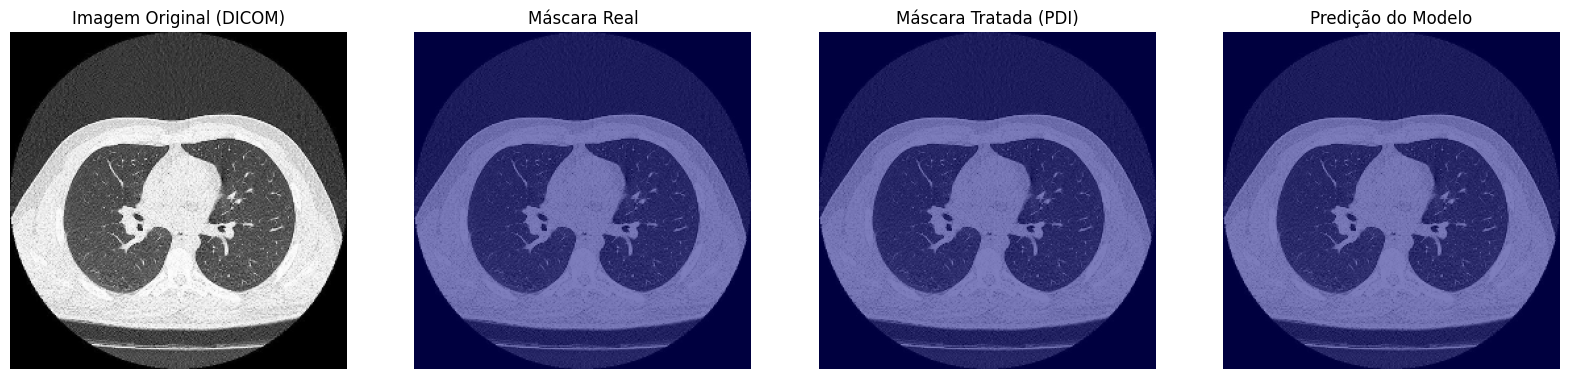

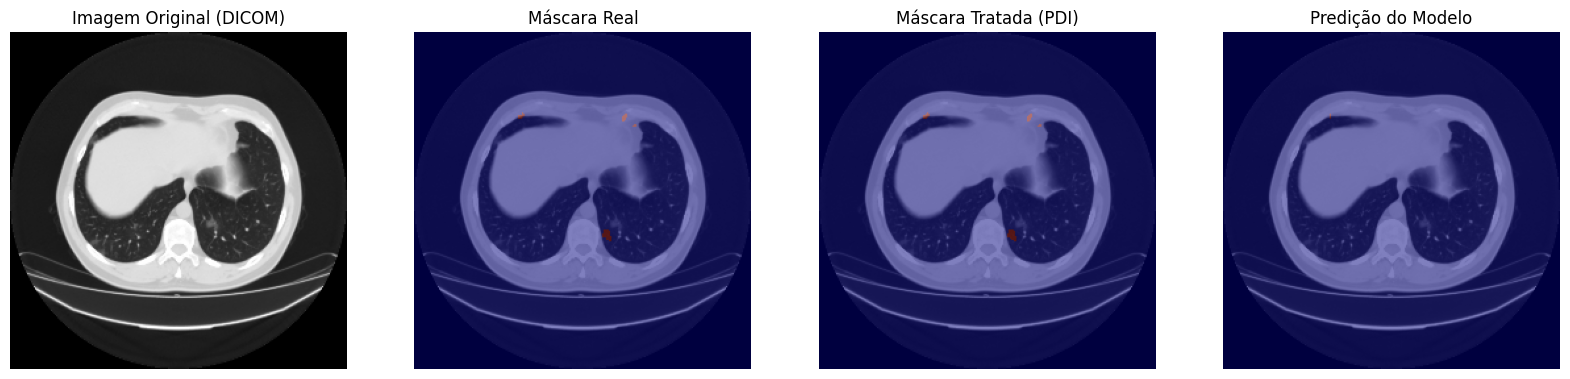

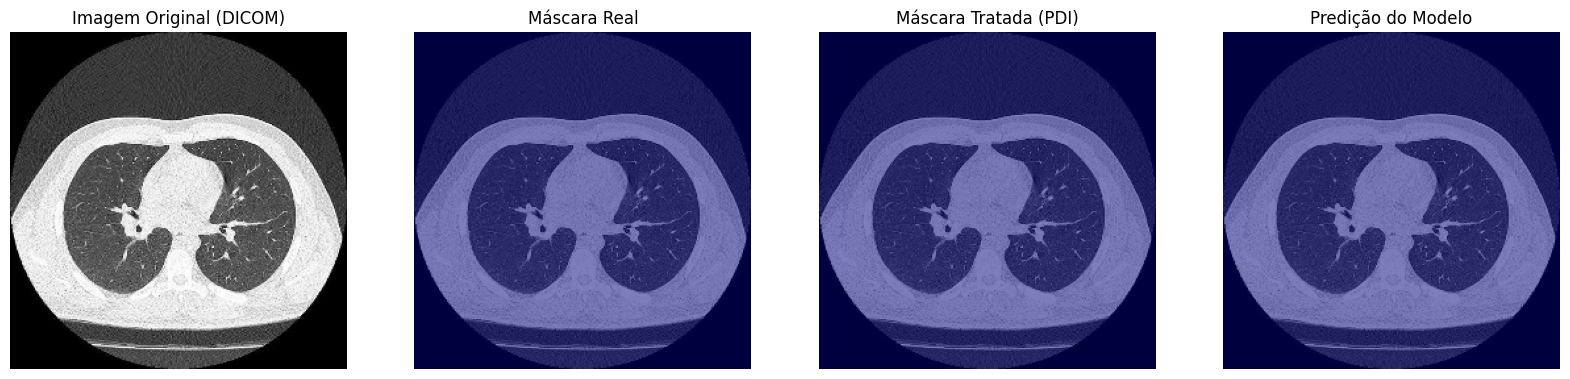

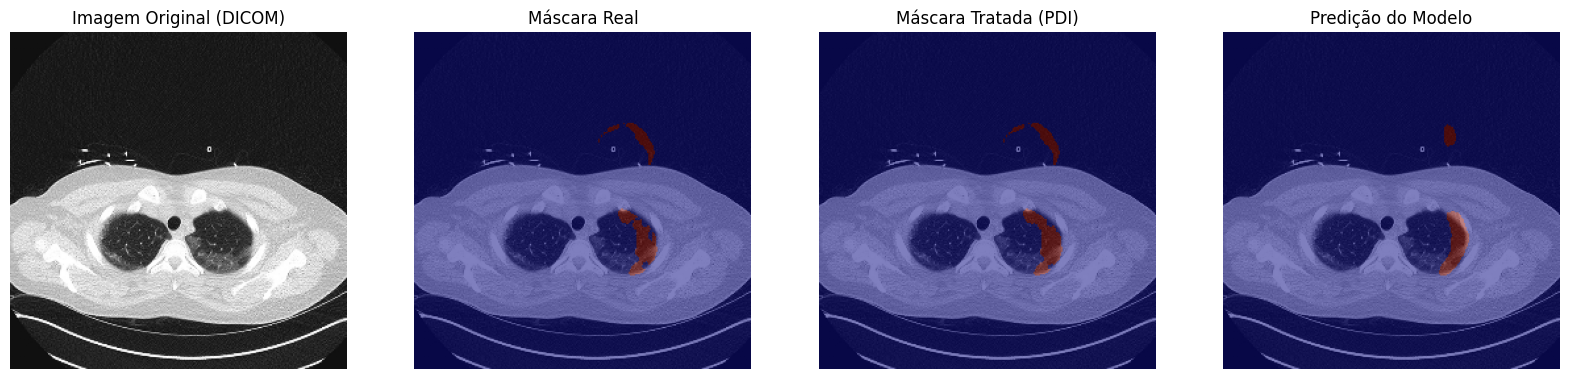

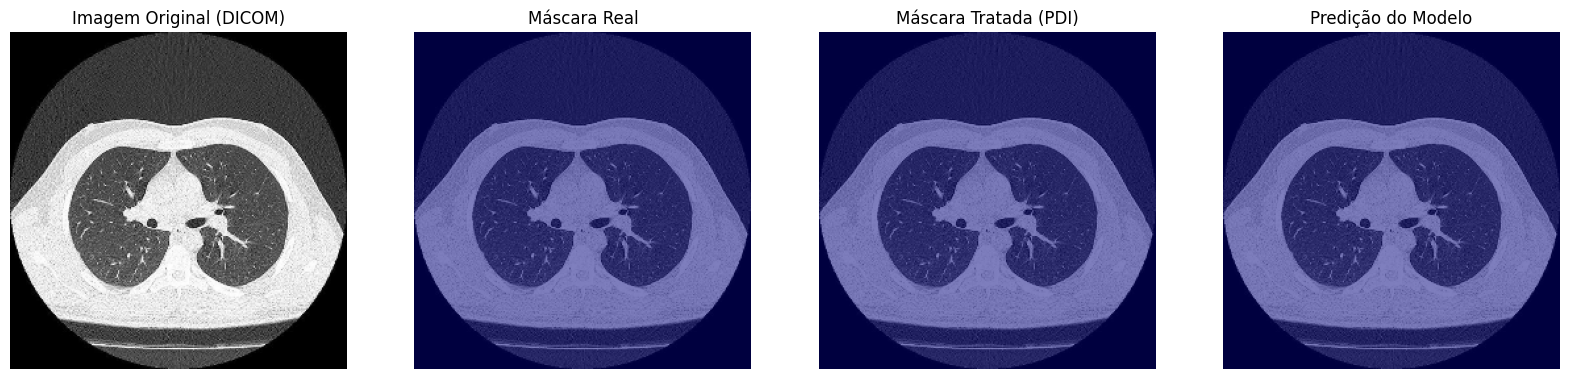

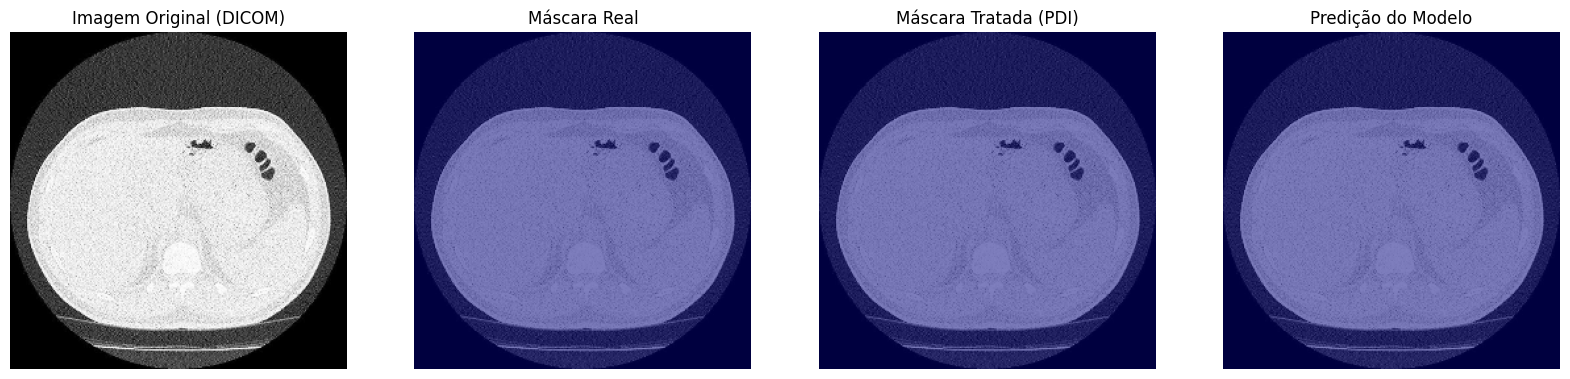

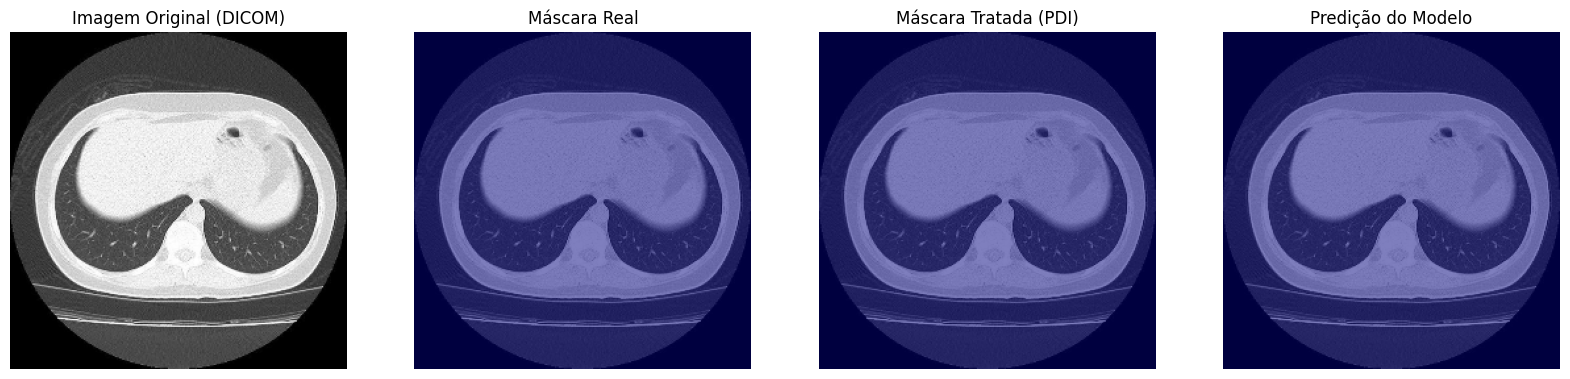

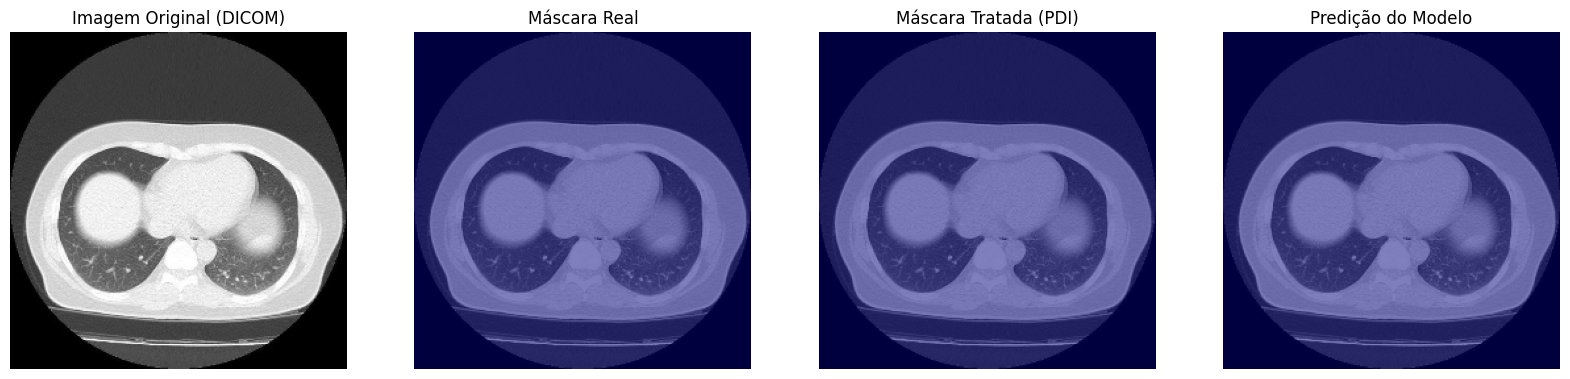

In [26]:
def close_mask_holes(mask_np, kernel_size=5):
    import cv2
    mask_uint8 = (mask_np * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    return closed_mask.astype(np.float32) / 255.0

model.eval()

image_batch, mask_batch = next(iter(test_dataloader))

with torch.no_grad():
    image_batch = image_batch.to(device)      
    mask_batch = mask_batch.to(device)       

    outputs = model(image_batch)           

    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).to(torch.uint8)

    if mask_batch.dim() == 3:
        mask_batch = mask_batch.unsqueeze(1) 

    mask_batch = mask_batch.to(torch.uint8)

    batch_size = image_batch.size(0)

    for i in range(batch_size):
        img = image_batch[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 255).astype(np.uint8)
        if img.shape[2] == 3 and np.all(img[:,:,0] == img[:,:,1]) and np.all(img[:,:,1] == img[:,:,2]):
            img = img[:,:,0]

        mask_np = mask_batch[i,0].cpu().numpy().astype(np.float32)
        mask_np /= mask_np.max() if mask_np.max() > 0 else 1

        # Aplica PDI simples para tratar máscara
        mask_treated = close_mask_holes(mask_np, kernel_size=5)

        pred_np = preds[i,0].cpu().numpy()

        plt.figure(figsize=(20,5))

        plt.subplot(1,4,1)
        plt.title("Imagem Original (DICOM)")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(1,4,2)
        plt.title("Máscara Real")
        plt.imshow(img, cmap='gray')
        plt.imshow(mask_np, alpha=0.5, cmap='jet')
        plt.axis('off')

        plt.subplot(1,4,3)
        plt.title("Máscara Tratada (PDI)")
        plt.imshow(img, cmap='gray')
        plt.imshow(mask_treated, alpha=0.5, cmap='jet')
        plt.axis('off')

        plt.subplot(1,4,4)
        plt.title("Predição do Modelo")
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_np, alpha=0.5, cmap='jet')
        plt.axis('off')

        plt.show()


In [38]:
model.eval()

total_tp = 0
total_fp = 0
total_fn = 0
total_tn = 0

with torch.no_grad():
    for images, masks in tqdm(test_dataloader, desc="Calculando Estatísticas Finais"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        
        preds = (torch.sigmoid(outputs) > 0.5).to(torch.uint8)
        
        masks = masks.to(torch.uint8)

        tp, fp, fn, tn = functional.get_stats(preds, masks, mode='binary')
        
        total_tp += tp.sum()
        total_fp += fp.sum()
        total_fn += fn.sum()
        total_tn += tn.sum()

epsilon = 1e-6

iou = functional.iou_score(total_tp, total_fp, total_fn, total_tn, reduction='micro')
dice = functional.f1_score(total_tp, total_fp, total_fn, total_tn, reduction='micro')
precision = functional.precision(total_tp, total_fp, total_fn, total_tn, reduction='micro')
recall = functional.sensitivity(total_tp, total_fp, total_fn, total_tn, reduction='micro')
specificity = functional.specificity(total_tp, total_fp, total_fn, total_tn, reduction='micro')

print("\n--- Resultados da Avaliação Estatística no Conjunto de Teste ---")
print(f"Total de Pixels (Verdadeiro Positivo): {total_tp.item()}")
print(f"Total de Pixels (Falso Positivo):    {total_fp.item()}")
print(f"Total de Pixels (Falso Negativo):     {total_fn.item()}")
print("-" * 55)
print(f"IoU (Jaccard) Geral: {iou.item():.4f}")
print(f"Dice (F1-Score) Geral: {dice.item():.4f}")
print(f"Precisão Geral:        {precision.item():.4f}")
print(f"Recall (Sensibilidade) Geral: {recall.item():.4f}")
print(f"Especificidade Geral:  {specificity.item():.4f}")
print("-" * 55)

Calculando Estatísticas Finais: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s]

Salvos 16 métricas em metricas.json

--- Resultados da Avaliação Estatística no Conjunto de Teste ---
Total de Pixels (Verdadeiro Positivo): 16885
Total de Pixels (Falso Positivo):    17625
Total de Pixels (Falso Negativo):     11350
-------------------------------------------------------
IoU (Jaccard) Geral: 0.3682
Dice (F1-Score) Geral: 0.5382
Precisão Geral:        0.4893
Recall (Sensibilidade) Geral: 0.5980
Especificidade Geral:  0.9978
-------------------------------------------------------
